# Adaptive PDE discretizations on cartesian grids
## Volume : Non-divergence form PDEs## Part : Application examples
## Chapter : Boat routing, time dependent


In this notebook, we compute the optimal route for a boat under the following assumptions:
- The objective is to minimize the fuel consumption, for a prescribed the travel time, or window of travel times.
- The boat fuel consumption is locally a quadratic function of its relative velocity, w.r.t. water.
- The boat total velocity is the sum of the relative velocity w.r.t water and of a drift due to water currents.

**Discussion of the assumptions**

These assumptions chosen above are a strong simplification of reality. Some of them may be relaxed, at the price of more complexity in the implementation. 
- The boat velocity model can be complexified. In fact, the method described below can handle any convex cost, approximated in a suitable manner. However, determining this cost (which depends on the physical properties of the boat), and approximating it (fitting a convex set with an intersection of ellipsoids), may raise difficulties in itself. 
- The problem considered here is time dependent. However, if time dependency is not a prerequisite for the application, then a much simpler and faster alternative numerical method can be considered, described in [another notebook](../Notebooks_FMM/BoatRouting).

**Time and space complexity**

The numerical approach presented below (time dependent problem) is orders of magnitude slover than the fast marching method discussed in [the other notebook](../Notebooks_FMM/BoatRouting) (static problem), and uses orders of magnitude more memory. However, the time dependent method should not be immediately dismissed on this account, since there are huge unexploited optimization opportunities. (Which may be illustrated in a future notebook.)
- *Time complexity.* The time dependent method is embarassingly parallel, and one may easily take advantage of GPU computing power. Speed improvements by a factor 100 are not unlikely.
- *Space complexity.* Bactracking the minimal paths requires to visit the PDE solution in reverse time. Currently, we keep a complete history of the computations, which has a huge memory cost. A more reasonable implementation would use landmarks, possibly in a recursive manner, and recompute some parts of the solution on the fly as needed.

[**Summary**](Summary.ipynb) of volume Non-Divergence form PDEs, this series of notebooks.

[**Main summary**](../Summary.ipynb) of the Adaptive Grid Discretizations 
	book of notebooks, including the other volumes.

# Table of contents
  * [1. The model and numerical scheme](#1.-The-model-and-numerical-scheme)
  * [2. Constant medium in space and time](#2.-Constant-medium-in-space-and-time)
    * [2.1 Formal checks](#2.1-Formal-checks)
    * [2.2 Comparison with an exact solution](#2.2-Comparison-with-an-exact-solution)
  * [3. Varying medium in space, constant in time](#3.-Varying-medium-in-space,-constant-in-time)
    * [3.1 Calling the eikonal solver](#3.1-Calling-the-eikonal-solver)
    * [3.2 Time dependent solver](#3.2-Time-dependent-solver)
    * [3.3 Comparison of the results](#3.3-Comparison-of-the-results)
  * [4. Extracting the optimal paths](#4.-Extracting-the-optimal-paths)
    * [4.1 Obtaining the geodesic flow](#4.1-Obtaining-the-geodesic-flow)
    * [4.2 Backtracking the geodesics](#4.2-Backtracking-the-geodesics)
  * [5. Varying medium in space and time](#5.-Varying-medium-in-space-and-time)



**Acknowledgement.** The experiments presented in these notebooks are part of ongoing research, 
some of it with PhD student Guillaume Bonnet, in co-direction with Frederic Bonnans.

Copyright Jean-Marie Mirebeau, University Paris-Sud, CNRS, University Paris-Saclay

## 0. Importing the required libraries

In [24]:
import sys; sys.path.insert(0,"..") # Allow import of agd from parent directory (useless if conda package installed)
#from Miscellaneous import TocTools; print(TocTools.displayTOC('BoatRouting_Time','NonDiv'))

In [25]:
from agd import LinearParallel as lp
from agd import FiniteDifferences as fd
from agd import Selling
from agd import AutomaticDifferentiation as ad
from agd import Eikonal
from agd import Interpolation
from agd.Plotting import savefig; #savefig.dirName = 'Images/BoatRouting'

from agd.ExportedCode.Notebooks_FMM import BoatRouting

In [26]:
import numpy as np
import matplotlib.pyplot as plt

Utility functions

In [27]:
norm_infinity = ad.Optimization.norm_infinity 
def norm(x): return ad.Optimization.norm(x,axis=0) # L2 norm on first axis
from agd.ExportedCode.Notebooks_NonDiv.LinearMonotoneSchemes2D import streamplot_ij

def quiver(X,Y,U,V,subsampling=1,**kwargs):
    def f(Z): return Z[::subsampling,::subsampling]
    plt.quiver(f(X),f(Y),f(U),f(V),**kwargs)

In [28]:
#from itertools import accumulate # Accumulate with initial value only exists in Python >= 3.8
def accumulate(iterable, func, initial):
    yield initial
    for element in iterable:
        initial = func(initial, element)
        yield initial

In [29]:
def ReloadPackages():
    from Miscellaneous.rreload import rreload
    global lp,fd,Selling,ad,Interpolation
    lp,fd,Selling,ad,Interpolation = rreload([lp,fd,Selling,ad,Interpolation],"../..")

## 1. The model and numerical scheme

Our objective is to compute the total fuel consumption $C(x,t)$, needed to reach a point $x$ at time $t$, from initial conditions (discussed below). This cost obeys the Hamilton-Jacobi-Bellman PDE
$$
    \partial_t C(t,x) + \sup_v \Big( <\nabla_x C(t,x),v> - c(t,x,v)\Big) = 0,
$$
where $c(t,x,v)$ is the instantaneous fuel consumption of a boat moving at velocity $v$, around the point $x$ and at time $t$. As announced, the time independent case $c=c(x,v)$ is best handled by a different set of methods, and is discussed in [another notebook](../Notebooks_FMM/BoatRouting).

**Discussion on the cost function.**
For simplicity, we consider a quadratic cost, in the form
$$
    c(t,x,v) = \mu(t,x) + \frac 1 2 \|v-\omega(t,x)\|_{M(t,x)}^2,
$$
where the parameters have the following interpretation:
- $\mu(t,x)$ is the fuel consumption at rest (or any other penalization of time).
- $\omega(t,x)$ is the drift velocity.
- $M(t,x)$ is a positive definite tensor describing the domain geometry.

The numerical scheme proposed below can in principle be generalized to costs of the form 
$$
    c(t,x,v) = \sup_{\lambda\in \Lambda} a_\lambda(t,x) + <b_\lambda(t,x),v> + \|v\|^2_{c_\lambda(t,x)},
$$
where $a_\lambda$, $b_\lambda$, and $c_\lambda$ are arbitrary scalar, vector, and symmetric positive matrix. Any cost (with at least quadratic growth at infinity) can be approximated in this form.

**Elimination of the supremum in the PDE.**
Using the explicit expression of the cost function, we can simplify the HJB equation obeyed by the cost function.
In the case of the quadratic cost, we obtain 
$$
    \partial_t C(t,x) + < \nabla_x C(t,x),\omega(t,x)> + \frac 1 2 \|\nabla_x C(t,x)\|_{M(x)^{-1}}^2 - \mu(t,x) = 0
$$
The following expression will be more convenient:
$$
    \partial_t C(t,x) + \frac 1 2 \|\nabla_x C(t,x) + \eta(t,x)\|_{D(t,x)}^2 = \nu(t,x),
$$
where $D(t,x) = M(t,x)^{-1}$, $\eta(t,x) = M(t,x)\omega(t,x)$ and $\nu(t,x) = \mu(t,x) + \frac 1 2 \|\omega(t,x)\|_{M(t,x)}^2.$

In the case of the general cost, one can also eliminate the sup in the PDE, by interverting a sup and an inf, under suitable assumptions.

**Numerical scheme.**
We use an explicit scheme, which is monotone under a CFL condition. The key difficulty lies in the discretization of the quadratic first order term, which we do as follows
$$
    \|\nabla C(t,x)+\eta(t,x)\|^2_{D(x)} = \sum_{1 \leq i \leq n} \lambda_i(t,x) 
    \max\Big(0, \frac{C(t,x)-C(t,x-he_i)}h + <\eta(t,x),e_i>, \frac{C(t,x)-C(t,x+he_i)} h - <\eta(t,x),e_i>\Big)^2 + O(h).
$$
We denoted by $(\lambda_i,e_i)_{i=1}^n$ a decomposition of the tensors
$$
    D(t,x) = \sum_{1 \leq i \leq n} \lambda_i(t,x) e_i e_i^T,
$$
where $\lambda_i \geq 0$ and $e_i \in Z^d$. In practice, we use Selling's decomposition, so that $n=d (d+1)/2$, and more specifically $d=2$ and $n=3$.

**Boundary conditions.**
We assign an infinite cost to all points outside the domain, a.k.a outflow boundary conditions. In other words, the boat trajectories are constrained to remain within the domain.

In [30]:
def scheme_params(model_params):
    μ,ω,M = fd.common_field(model_params, depths=(0,1,2))    
    D = lp.inverse(M)
    η = lp.dot_AV(M,ω)
    ν = μ + 0.5*lp.dot_VAV(ω,M,ω)
    
    λ,e = Selling.Decomposition(D)
    return (ν,η,D,λ,e)

def Scheme(C,dt,dx,params,walls=False):
    C,β,η,_,λ,e = fd.common_field((C,)+params, depths=(0,0,1,2,1,2))
    η = np.expand_dims(η,axis=1)
                                  
    dCm = -fd.DiffUpwind(C,-e,dx,padding=np.inf) + lp.dot_VV(η,e)
    dCp = -fd.DiffUpwind(C, e,dx,padding=np.inf) - lp.dot_VV(η,e)
    dCNorm = (λ * np.maximum(0.,np.maximum(dCp,dCm))**2).sum(axis=0)

    return np.where(walls,np.inf, C + dt*(β - 0.5*dCNorm))

**CFL stability condition**
The numerical scheme is monotone provided the time step obeys $K_0\delta t < \delta x$, where $K_0$ depends on the Lipschitz constant of the solution, w.r.t the position $x$, and on the parameters $\omega$ and $M$. The constant $K_0$ is not hard to derive theoretically, see the function below.

**Initialization.** 
From the modeling standpoint, the fuel consumption would ideally be initialized at $0$ at the seed point, and $+\infty$ anywhere else. Unfortunately, the considered numerical scheme cannot handle such initial conditions, and will immediately produce NaNs.

Instead, we propose an initialization in the following form, assuming the seed point is the origin,
$$
    C(0,x) = K\|x\|.
$$
If the constant $K$ is chosen large enough, then all optimal paths of interest end up at the origin, and the corresponding fuel consumption is identical to the one corresponding to the ideal initialization.
This approach is referred to as *exact penalization*. The adequate value of $K$ is usually found by trial and error. Theoretical bounds exist, but they are typically too pessimistic to be usable in practice.

**Stability of the Lipschitz constant**
If the initial condition is $K$-Lipschitz, and $K\geq K_1$ where $K_1$ depends on the parameters $\omega$ and $M$, then continuous solution remains $K$-Lipschitz at all times. Likewise for the numerical solution provided the time step obeys the CFL condition. 
Theoretical bounds exist for the constant $K_1$, in terms of the Lipschitz constants of $\omega$ and $M$. However, they are exponential w.r.t time and typically too pessimistic to be usable in practice. Again, a trial and error approach is preferred.

In [31]:
def CFL(K,dx,params):
    """Returns the largest time step dt for which the scheme is monotone.
    - K : Lipschitz constant of the solution w.r.t the space variable."""
    _,η,_,λ,e = params
    K_0 = (K+norm(η))*(λ*norm(e)).sum(axis=0)
    return dx/np.max(K_0)

## 2. Constant medium in space and time

We validate the numerical scheme by considering a constant medium, in space and time, for which we know the exact solution.

In [32]:
# Parameters : unit weight for time, unit horizontal drift, euclidean geometry
model_params = (1.,np.array((1.,0.)),np.eye(2))
params = scheme_params(model_params) 

# Coordinate system
aX,dx = np.linspace(-1,1,retstep=True)
X = np.meshgrid(aX,aX,indexing='ij')

# Initial condition
K_Lip = 3.
C_initial = K_Lip * ad.Optimization.norm(X,axis=0)
dt = CFL(K_Lip,dx,params)

### 2.1 Formal checks

Let us perform some basic checks on the scheme. First, it must preserve positivity.

In [33]:
C1 = Scheme(C_initial,dt,dx,params)
print(f"Smallest and largest value after one step : {np.min(C1)}, {np.max(C1)}")
assert np.min(C1)>=0 and np.isfinite(np.max(C1))

Smallest and largest value after one step : 0.09168654463508756, 4.23596965297735


Second, it is a monotone scheme.

In [34]:
C_initial_ad = ad.Sparse.identity(constant=C_initial)
C1_ad = Scheme(C_initial_ad,dt,dx,params)
C1_ad.simplify_ad()

print(f"Smallest and largest jacobian coefficient after one step : {np.min(C1_ad.coef)}, {np.max(C1_ad.coef)}")
assert np.min(C1_ad.coef)>=0 and np.isfinite(np.max(C1_ad.coef))

Smallest and largest jacobian coefficient after one step : 0.0, 1.0


Monotony is invalidated if we choose an excessively large time step, not obeying the CFL condition. (Which is not sharp btw.)

In [35]:
C_initial_ad = ad.Sparse.identity(constant=C_initial)
C1_ad = Scheme(C_initial_ad,2*dt,dx,params)
C1_ad.simplify_ad()
print(f"Smallest and largest jacobian coefficient after one step : {np.min(C1_ad.coef)}, {np.max(C1_ad.coef)}")

Smallest and largest jacobian coefficient after one step : -0.2996128269073922, 1.0


### 2.2 Comparison with an exact solution

A formal analysis, led in [another notebook](../Notebooks_FMM/BoatRouting), yields the optimal route in a constant medium in space and time

In [36]:
route = BoatRouting.route_min(X,model_params)

In particular, we know the time of the longest optimal path.

In [37]:
t_max = np.max(route['time'])
t_range = np.arange(0,t_max+dt,dt)

In [38]:
C_solution = np.array(list(accumulate(
    t_range[1:],
    initial=C_initial, 
    func=lambda C_t,t: Scheme(C_t,dt,dx,params)
)))

In [39]:
assert np.allclose(C_solution[0],C_initial) and np.allclose(C_solution[1],C1)

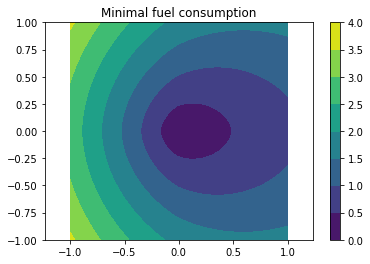

In [40]:
C_opt = np.min(C_solution,axis=0); 
plt.title("Minimal fuel consumption"); plt.axis('equal')
plt.contourf(*X,C_opt); plt.colorbar();

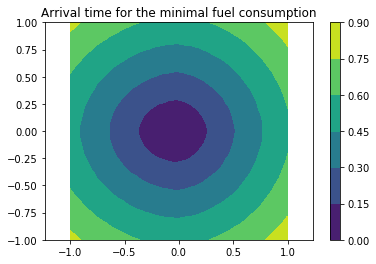

In [41]:
t_opt = t_range[np.argmin(C_solution,axis=0)]
plt.title("Arrival time for the minimal fuel consumption"); plt.axis('equal')
plt.contourf(*X,t_opt); plt.colorbar();

The numerical solution agrees with the exact solution, up to discretization error. Note that the scheme is only first order in space and time.

In [42]:
C_error = norm_infinity(C_opt-route['cost'])
t_error = norm_infinity(t_opt-route['time'])
print(f"Error on the optimal cost: {C_error}, and on the arrival time for the optimal cost: {t_error}")

Error on the optimal cost: 0.20104703516072542, and on the arrival time for the optimal cost: 0.07942048941013019


In [43]:
assert C_error<0.25 and t_error<0.1

## 3. Varying medium in space, constant in time

We choose a constant medium in time, varying in space, so as to be able to compare our results with the static approach based on the fast marching algorithm. The test case is the same as in [the other notebook](../Notebooks_FMM/BoatRouting).

### 3.1 Calling the eikonal solver

We compute a reference solution based on the fast marching algorithm. The HFM library must be installed for this step to execute.

In [44]:
hfmIn = Eikonal.dictIn({
    'verbosity':0,
    'model':'Rander2', # Riemannian + drift, what is needed here
    'exportValues':1,
    'exportGeodesicFlow':1,
    'seeds':[[-1.7,0.6]], # Where to start the front propagation
})
hfmIn.SetRect([[-2,2],[-1,1]],dimx=200) # Rectangular domain
X = hfmIn.Grid() # Coordinate system
hfmIn.update({
    'tips':hfmIn.Grid(dims=(6,3)).reshape(2,-1).T, # Points from which to backtrack geodesics
    'walls':X[1]-np.abs(X[0])>=0, # Obstacles in the domain
})

In [45]:
Embed_ω = BoatRouting.Currents(*X)
Embed_M = BoatRouting.IntrinsicMetric(BoatRouting.Spherical,*X)
model_params = (1.,Embed_ω,Embed_M)
params = scheme_params(model_params)

In [46]:
arrival_time,hfmOut = BoatRouting.ArrivalTime(hfmIn,model_params)

### 3.2 Time dependent solver

In [47]:
K_Lip = 3.
C_initial = K_Lip * norm(X- fd.as_field(hfmIn['seeds'][0],hfmIn.shape))
C_initial[hfmIn['walls']] = np.inf
dx = hfmIn['gridScale']
dt = CFL(K_Lip,dx,params)

t_max = np.nanmax(arrival_time) # Cheating a bit: the latest arrival time is already known
t_range = np.arange(0,t_max+dt,dt)

The solution of the time dependent PDE is more compute intensive that the static one.

In [48]:
%%time
C_solution = np.array(list(accumulate(
    t_range[1:],
    initial=C_initial, 
    func=lambda C_t,t: Scheme(C_t,dt,dx,params,walls=hfmIn['walls'])
)))

../agd/FiniteDifferences.py:103: RuntimeWarning: invalid value encountered in add
  return sum(TakeAtOffset(u,mult*np.asarray(offset),**kwargs)*weight


CPU times: user 24.5 s, sys: 1.1 s, total: 25.6 s
Wall time: 26.1 s


### 3.3 Comparison of the results

The arrival times computed by both methods match fairly well in the average. The largest difference arises where close to the cut-locus. This is not surprising, since the arrival time is discontinuous along a line in this region.

In [49]:
C_opt = np.min(C_solution,axis=0)
t_opt = t_range[np.argmin(C_solution,axis=0)]

In [50]:
t_diff_avg = np.nanmean(np.abs(t_opt - arrival_time))
print(f"Average absolute difference of the arrival times {t_diff_avg}")

Average absolute difference of the arrival times 0.023535340023891037


In [51]:
assert t_diff_avg < 0.03

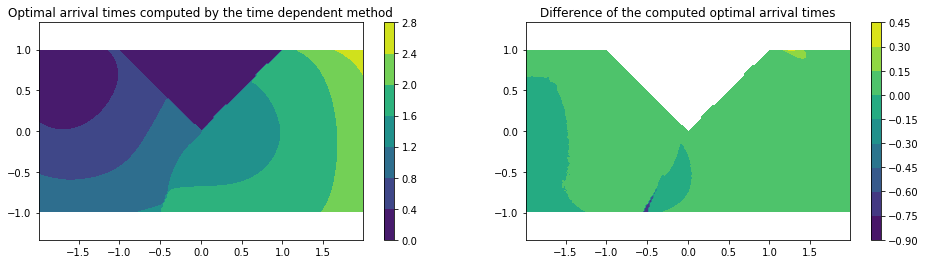

In [52]:
plt.figure(figsize=[16,4])

plt.subplot(1,2,1); plt.axis('equal')
plt.title("Optimal arrival times computed by the time dependent method")
plt.contourf(*X,t_opt); plt.colorbar()

plt.subplot(1,2,2); plt.axis('equal')
plt.title("Difference of the computed optimal arrival times")
plt.contourf(*X,t_opt-arrival_time); plt.colorbar();

The computed costs agree well, except along the eastern boundary of the excluded region. The difficulty lies in the fact that some minimal paths go tangentially along this eastern boundary.

<!---
The reason, I expect, is that the strong current in the east induces very strong anisotropy in the problem. As a result, the fast-marching method uses rather wide stencils, which decrease its accuracy in this region. (We use FM-ASR, fast-marching using adaptive stencil refinement.) 
The GPU eikonal solver is based on a different numerical scheme, which may agree better here. (TODO: check)
--->

In [53]:
walls = hfmIn['walls']
C_opt[walls] = np.nan; hfmOut['values'][walls] = np.nan
C_diff_avg = np.nanmean(np.abs(C_opt - hfmOut['values']))

In [54]:
print(f"Average difference of cost {C_diff_avg}")

Average difference of cost 0.14871065784189996


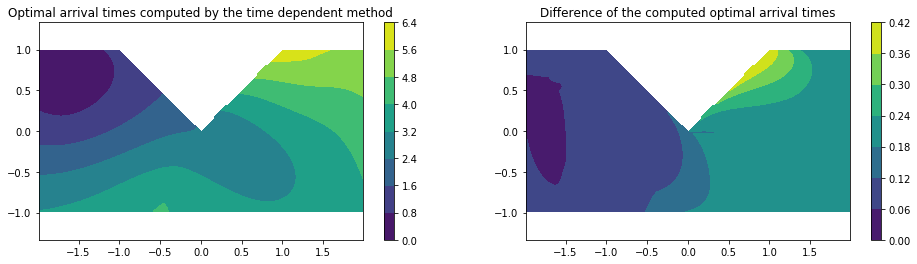

In [55]:
plt.figure(figsize=[16,4])

plt.subplot(1,2,1); plt.axis('equal')
plt.title("Optimal arrival times computed by the time dependent method")
plt.contourf(*X,C_opt); plt.colorbar()

plt.subplot(1,2,2); plt.axis('equal')
plt.title("Difference of the computed optimal arrival times")
plt.contourf(*X,C_opt-hfmOut['values']); plt.colorbar();

## 4. Extracting the optimal paths

The velocity $v$ of the boat, along the optimal trajectory at a time $t$ and position $x$, is characterized by the equation
$$
    \nabla_x C(t,x) = \nabla_v c(t,x,v).
$$
Specializing to the quadratic cost, we obtain 
$$
    \nabla_x C(t,x) = M(t,x) (v - \omega(t,x)),
$$
equivalently, with $D = M^{-1}$ and $\eta = M \omega$,
$$
    v = D(t,x) (\nabla_x C(t,x) + \eta(t,x) ).
$$
We refer to $v=V(t,x)$ as the geodesic flow, although the `geodesic` term only makes sense in the static case, and extract it numerically using the above formula, and a basic first order approximation of the gradient.
Once it is known, the optimal trajectories can be backtracked by solving the ODE 
$$
    x'(t) = V(t,x(t)),
$$
in reverse time, with a prescribed terminal condition $x(t_F) = x_F$.

### 4.1 Obtaining the geodesic flow

The next function is used broadcast the arrays $D$ and $\eta$ as time and space dependent data. The following one interpolates these fields as well as the cost values, differentiates the cost, and evaluates the flow.

In [56]:
def as_fieldT(array,st,sx,depth):
    """
    Broadcast an array, if needed, as a time dependent field.
    st : number of time steps, sx : shape w.r.t x
    """
    s = array.shape[depth:]
    vdim = len(sx)
    if   len(s)==0:    s = (1,)*(vdim+1)
    elif len(s)==1:    s = s+(1,)*vdim
    elif len(s)==vdim: s = (1,)+s
    r = array.shape[:depth]
    return np.broadcast_to(np.reshape(array,r+s),r+(st,)+sx)

In [57]:
def flow(T,X,C,η,D):
    """
    Return a callable providing the velocity of the minimal path at each time and position.
    η and D expected to be time and space dependent, broadcasted otherwise.
    """
    grid = {'shape':(len(T),)+X.shape[1:], # We do not generate the full grid, to save memory
            'origin':(T[0],)+tuple(X[:,0,0]),
            'scale':(T[1]-T[0],) + tuple(X[:,1,1]-X[:,0,0]),}
    η = as_fieldT(η,len(T),X.shape[1:],depth=1)
    D = as_fieldT(D,len(T),X.shape[1:],depth=2)    
    C,η,D = (Interpolation.UniformGridInterpolation(grid,e) for e in (C,η,D))
    def call(t,x): 
        t=np.expand_dims(t,axis=0) # for concatenation
        tx = np.concatenate((t,x),axis=0)
        η_ = η(tx); D_ = D(tx)
        x_ad = ad.Dense.identity(constant=x, shape_free=(len(x),))
        tx_ad = np.concatenate((t,x_ad),axis=0) # Differentiate value w.r.t x only
        C_grad_x = C(tx_ad).gradient()
        return lp.dot_AV(D_,C_grad_x + η_)
    return call

The flow computed by the time dependent PDE, and by the static PDE, agree well once the latter is appropriately rescaled. The largest differences are seen at the seed, at the cut-locus (where the flow is discontinuous), and along the right side of the obstacle.

In [58]:
_,η,D,_,_ = params
flow_time = flow(t_range,X,C_solution,η,D)
flow_opt_time = flow_time(t_opt,X)

route = BoatRouting.route_min(hfmOut['flow'],model_params)
flow_static = hfmOut['flow']/route['time']

../agd/AutomaticDifferentiation/Dense.py:64: RuntimeWarning: invalid value encountered in multiply
  return self.new(self.value*other,_add_dim(other)*self.coef)


In [59]:
flow_diff_norm = norm(flow_opt_time-flow_static)
print(f"Average norm of difference between the flow at optimal time, and the static flow: {np.nanmean(flow_diff_norm)}")

Average norm of difference between the flow at optimal time, and the static flow: 0.12034197191734133


In [60]:
assert np.nanmean(flow_diff_norm)<0.2

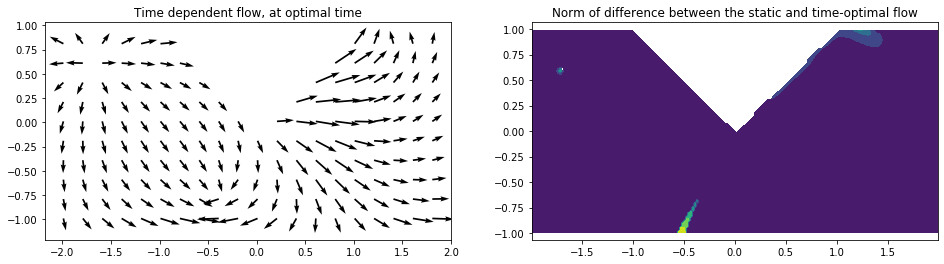

In [61]:
plt.figure(figsize=[16,4])

plt.subplot(1,2,1); plt.axis('equal')
plt.title("Time dependent flow, at optimal time")
quiver(*X,*flow_opt_time,subsampling=10)

plt.subplot(1,2,2); plt.axis('equal')
plt.title("Norm of difference between the static and time-optimal flow")
plt.contourf(*X,flow_diff_norm)
#quiver(*X,*flow_static,subsampling=10)

### 4.2 Backtracking the geodesics

In order to integrate this flow, we need an ODE solver. We use here a two-lines implementation of the Euler midpoint scheme. For practical applications, a faster and more robust ODE solver is definitely needed. (The C++ implementation of the HFM library does not suffer from these flaws.)

**Note on computation time.** Currently the geodesic backtracking is extremely slow. This is purely an implementation problem, since the actual amount of computation happening is quite small - at least a hundred times smaller in terms of floating point operations than for the computation of the PDE solution. We hope to fix this performance issue at some point.

**Note on the tip of the obstacle.** The backtracked geodesics, from the time dependent PDE, stop when they go past the tip of the obstacle. The solution is indeed non-differentiable at this point, which makes backtracking difficult. Again, a fix is needed.

In [62]:
def Euler_midpoint(t,x,V,dt):
    """One step of the Euler midpoint scheme"""
    tm = t+dt/2.; xm=x+V(t,x)*dt/2. # Midpoint time and position
    return x+V(tm,xm)*dt

def odesolve(T,x,V,step):
    return np.array(list(accumulate(
        np.asarray([T[1:],np.diff(T)]).T,
        initial=x,
        func=lambda x,t_dt : step(t_dt[0],x,V,t_dt[1])
    ))).T

In [247]:
geodesics = []
for x in hfmIn['tips']:
    xi,_ = hfmIn.IndexFromPoint(x)
    ti = np.argmin(C_solution.__getitem__((slice(None),*xi)))
    T = t_range[:ti+1][::-1]
    geodesics.append(odesolve(T,x,flow_time,Euler_midpoint))

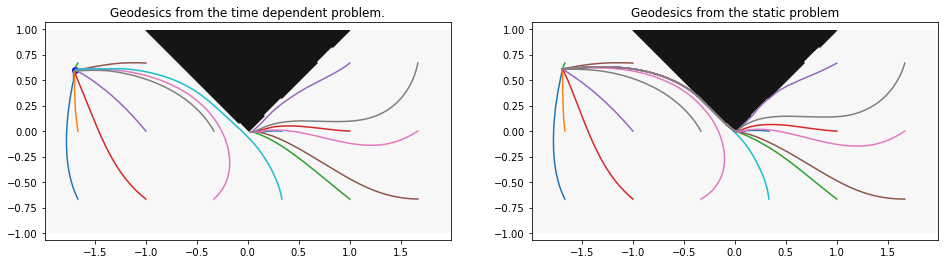

In [256]:
plt.figure(figsize=[16,4]); plt.axis('equal')

plt.subplot(1,2,1); plt.axis('equal')
plt.title("Geodesics from the time dependent problem.")
plt.contourf(*X,hfmIn['walls'],cmap='Greys')
plt.scatter(*hfmIn['seeds'][0],color='blue')
for geo in geodesics: plt.plot(*geo)
    
plt.subplot(1,2,2); plt.axis('equal')
plt.title("Geodesics from the static problem")
plt.contourf(*X,hfmIn['walls'],cmap='Greys')
for geo in hfmOut['geodesics']: plt.plot(*geo)

The geodesics should merge into one after the the obstacle, but only the ODE solver implemented in the HFM library achieves this yet.

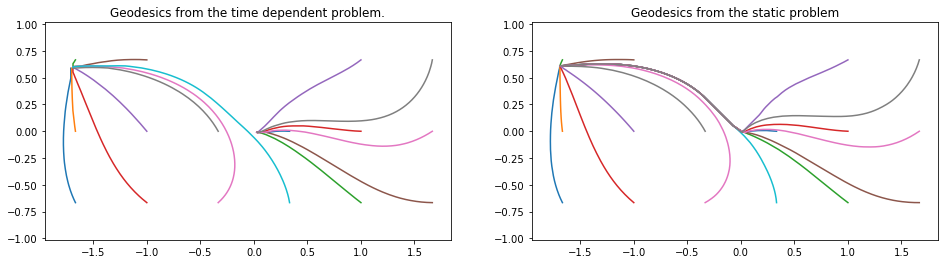

In [257]:
plt.figure(figsize=[16,4]); plt.axis('equal')

plt.subplot(1,2,1); plt.axis('equal')
plt.title("Geodesics from the time dependent problem.")
for geo in geodesics: plt.plot(*geo)
    
plt.subplot(1,2,2); plt.axis('equal')
plt.title("Geodesics from the static problem")
for geo in hfmOut['geodesics']: plt.plot(*geo)

*Hidden profiling attempt*

<!---
ReloadPackages()

x = hfmIn['tips'][0]
xi,_ = hfmIn.IndexFromPoint(x)
ti = np.argmin(C_solution[tuple(xi)])
T = t_range[:ti+1][::-1]

import cProfile
cProfile.run("odesolve(T,x,flow_time,Euler_midpoint)",'profile_stats')

import pstats
p = pstats.Stats('profile_stats')
p.sort_stats('time').print_stats(20)
--->

## 5. Varying medium in space and time

The discretization of the time dependent method, presented above, applies with almost no modification to a time dependent vector field $\omega(t,x)$, and geometry $D(t,x)$.